<div class="alert alert-info"><h3>DeepAR: Univariate Time Series Analysis</h3><br>
    <a>Master Thesis: Machine  Learning  basierstes  Forecasting  des  Elektromobilitätshochlaufs  in  Deutschland</a><br>
    <a>Name: Taj Mohammad Ghulam Zada</a><br>
    <a>Hochschule: Technische Hochschule Brandenburg</a><br>
    <a>Semester: 5</a><br>
    <a>Datum: 01. Dezember 2022</a><br>
</div>


 **Source:**
* https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html
* https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/
* https://ts.gluon.ai/stable/tutorials/advanced_topics/hp_tuning_with_optuna.html
* https://deepnote.com/@kekayan/Time-Series-Forecastings-66d2eb6a-ea56-4568-b65d-f61fcc0dc465

# Importing Libraries

In [1]:
import pandas as pd                                                             # For Tabular Datas
import numpy as np                                                              # For Dimensional ND-Array Data
import mxnet as mx                                                              # To add seed and avoid getting random prediction values
import matplotlib.pyplot as plt                                                 # For Visualisation purposes
#import Redshift_lib                                                            # To convert SQL Data from AWS to a Dataframe
from itertools import islice                                                    # To slice and iter inside a list
from gluonts.dataset.common import ListDataset                                  # Train Test Split and config Dataset in DeepAR
from gluonts.model.deepar import DeepAREstimator                                # To create an instance of DeepAR-Estimator and train the model
from gluonts.mx import Trainer                                                  # Trainer Model to customize on how to train the model
from gluonts.evaluation.backtest import make_evaluation_predictions             # To evaluate and predict the model performance in DeepAR
from gluonts.evaluation import Evaluator                                        # To evaluate model and asses the error in Forecasting
from gluonts.dataset.util import to_pandas                                      # Panda capabilities in DeepAR
import time                                                                     # For "Time" use cases
import optuna                                                                   # For Hyperparameter Tuning with Optuna
from optuna.samplers import TPESampler                                          # Type of Optuna sampler
import warnings                                                                 # Ignore unharmful messages
import joblib                                                                   # For saving Optuna Study
from pathlib import Path                                                        # For saving trained DeepAR-Model
from gluonts.model.predictor import Predictor                                   # For loading back the trained DeepAR-Model
warnings.filterwarnings("ignore")                                               # Supress Warnings
import seaborn as sns                                                           # Achieve better Visualization with Seaborn
#sns.set()                                                                      # Set Seaborn as default for visualization



### To make Plots in Python bigger:
#from pylab import rcParams                                                     # Importing rcParams
#rcParams['figure.figsize'] = 9,6

# Loading dataset

* Varibale: Market-share (%) of BEV-PKW new registration in Germany
* Taget values: Market-share (%) of BEV-PKW new registration in Germany
* Index: Datum

In [2]:
# Reading CSV-File
# Here we originally used the Redshift-SQL Code to achieve the raw data.
df1 = pd.read_csv('Path/To/Dataset/Univariate_BEV_PKW_Dataset.csv', index_col='datum', parse_dates=True)
df1.head()

Batterieelektrisch
datum                         
2017-01-01                0.55
2017-02-01                0.63
2017-03-01                0.61
2017-04-01                0.49
2017-05-01                0.47

# Explorative Data Analysis (EDA)
Creating a checkpoint:

In [3]:
# Creating checkpoint
df = df1.copy()
df.columns = ["Anteil_BEV_PKW_Deutschland"]
# Checking data description i.e. Mean, Min, Max, etc.
df.describe()

Anteil_BEV_PKW_Deutschland
count                   69.000000
mean                     5.977246
std                      6.155779
min                      0.470000
25%                      1.030000
50%                      2.030000
75%                     10.770000
max                     21.280000

In [4]:
# Checking Data status i.e. Missing Values etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2017-01-01 to 2022-09-01
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Anteil_BEV_PKW_Deutschland  69 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [5]:
# Setting the DF frequency to per Month oder 'MS'
df.index = pd.to_datetime(df.index)
df.index.freq = 'MS'
# dataset = dataset.asfreq('MS') # Alternative Method
# Checking index if the changes were applied
df.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
      

In [6]:
# Checking missing values
df.isna().sum()

Anteil_BEV_PKW_Deutschland    0
dtype: int64

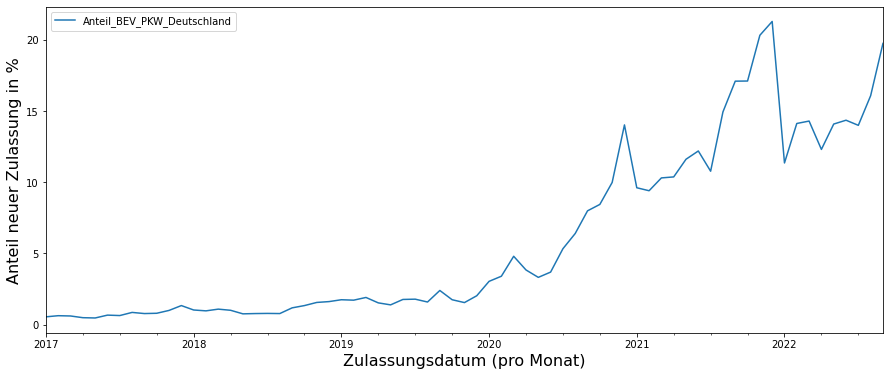

In [7]:
# Visualization of the input data
df.plot(figsize=(15,6))
#plt.title('Neu Zulassung BEV-PKWs in 33 Ländern', size=22)
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.show()

In [8]:
df.tail(7)

Anteil_BEV_PKW_Deutschland
datum                                 
2022-03-01                       14.29
2022-04-01                       12.30
2022-05-01                       14.08
2022-06-01                       14.35
2022-07-01                       13.99
2022-08-01                       16.07
2022-09-01                       19.74

# Train Test Split

* Training Dataset:  92% = 60 Monaten
* Test Dataset:       8% = 6  Monaten

In [9]:
# Creating the Training Dataset
training_data = ListDataset(
    [
        {
            "start": df.index[0],                                           # Starting Date in Training Dataset
            "target": df["Anteil_BEV_PKW_Deutschland"][:"2022-03-01"],      # End Date + Data for Training Dataset
            "item_id" : "Anteil_BEV_PKW_Deutschland"                        # Name for this product – Only useful if we had many products to forecast simultaneously.
        }
    ],
    freq="M"                                                                # Data Frequency – For Monthly Data it is always "M", Quarterly "Q", yearly "Y2 etc.
)

# Creating Test Dataset
test_data = ListDataset(
    [
        {
            "start": df.index[0],                                           # Starting Date in Test Dataset
            "target": df["Anteil_BEV_PKW_Deutschland"][:"2022-09-01"],      # End Date + Data for Test Dataset
            "item_id" : "Anteil_BEV_PKW_Deutschland"                        # Name for this product – Only useful if we had many products to forecast simultaneously.
        }
    ],
    freq = "M"                                                              # Data Frequency – For Monthly Data it is always "M", Quarterly "Q", yearly "Y2 etc.
)

In [10]:
# Checking the entry of Train Dataset
# Iterating the Dataset to checkt the keys
train_entry = next(iter(training_data))
# Shows the keys for the values
train_entry.keys()

dict_keys(['start', 'target', 'item_id'])

In [11]:
# Checking Iterm ID
train_entry['item_id']

'Anteil_BEV_PKW_Deutschland'

In [12]:
# Checking values in Training Dataset
train_entry

{'start': Period('2017-01', 'M'),
 'target': array([ 0.55,  0.63,  0.61,  0.49,  0.47,  0.67,  0.64,  0.86,  0.78,
         0.8 ,  1.  ,  1.34,  1.03,  0.97,  1.09,  1.01,  0.76,  0.78,
         0.79,  0.78,  1.18,  1.34,  1.56,  1.62,  1.75,  1.72,  1.91,
         1.53,  1.39,  1.77,  1.79,  1.59,  2.4 ,  1.75,  1.55,  2.03,
         3.04,  3.4 ,  4.8 ,  3.84,  3.32,  3.69,  5.33,  6.4 ,  7.99,
         8.44,  9.98, 14.02,  9.61,  9.4 , 10.3 , 10.37, 11.61, 12.19,
        10.77, 14.93, 17.09, 17.1 , 20.31, 21.28, 11.35, 14.12, 14.29],
       dtype=float32),
 'item_id': 'Anteil_BEV_PKW_Deutschland'}

In [13]:
# Converting Training Data into Pandas DataFrame
to_pandas(next(iter(training_data))).tail()

2021-11    20.309999
2021-12    21.280001
2022-01    11.350000
2022-02    14.120000
2022-03    14.290000
Freq: M, dtype: float32

In [14]:
# Checking the entry of Test Dataset
# Iterating the Test Dataset
test_entry = next(iter(test_data))
# Shows the keys for the values
test_entry.keys()

dict_keys(['start', 'target', 'item_id'])

In [15]:
# Checking Test Dataset's values
test_entry

{'start': Period('2017-01', 'M'),
 'target': array([ 0.55,  0.63,  0.61,  0.49,  0.47,  0.67,  0.64,  0.86,  0.78,
         0.8 ,  1.  ,  1.34,  1.03,  0.97,  1.09,  1.01,  0.76,  0.78,
         0.79,  0.78,  1.18,  1.34,  1.56,  1.62,  1.75,  1.72,  1.91,
         1.53,  1.39,  1.77,  1.79,  1.59,  2.4 ,  1.75,  1.55,  2.03,
         3.04,  3.4 ,  4.8 ,  3.84,  3.32,  3.69,  5.33,  6.4 ,  7.99,
         8.44,  9.98, 14.02,  9.61,  9.4 , 10.3 , 10.37, 11.61, 12.19,
        10.77, 14.93, 17.09, 17.1 , 20.31, 21.28, 11.35, 14.12, 14.29,
        12.3 , 14.08, 14.35, 13.99, 16.07, 19.74], dtype=float32),
 'item_id': 'Anteil_BEV_PKW_Deutschland'}

In [16]:
# Converting Training Data into Pandas DataFrame
to_pandas(next(iter(test_data)))

2017-01     0.55
2017-02     0.63
2017-03     0.61
2017-04     0.49
2017-05     0.47
           ...  
2022-05    14.08
2022-06    14.35
2022-07    13.99
2022-08    16.07
2022-09    19.74
Freq: M, Length: 69, dtype: float32

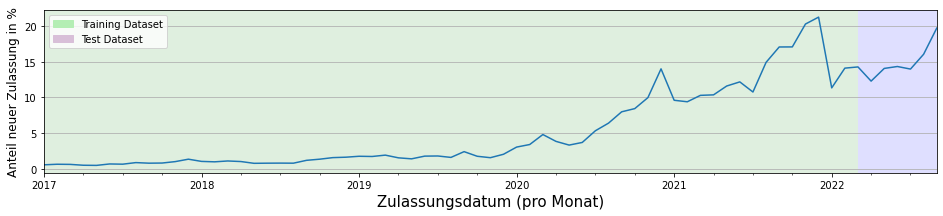

In [17]:
# Visualisation of Train-Test-Split in one Plot: Method 1
# Visualize Train Test Split Datasets
train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots()

df.plot(ax=ax,figsize=(16,3))
#ax.axvline(df_train.index[-1], color="r")  # End of Training dataset
plt.axvspan(train_series.index[0] , train_series.index[-1], facecolor="green", alpha=0.125)
plt.axvspan(train_series.index[-1], test_series.index[-1], facecolor="blue", alpha=0.125)
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=15)
plt.ylabel('Anteil neuer Zulassung in %' ,size=12)

# Creating legend with color box
import matplotlib.patches as mpatches
leg_col_training_dataset = mpatches.Patch(color='#B4EEB4', label="Training Dataset")
leg_col_test_dataset = mpatches.Patch(color='thistle', label="Test Dataset")

ax.legend(loc="upper left", handles=[leg_col_training_dataset, leg_col_test_dataset])
plt.grid(axis = 'y')
plt.show()

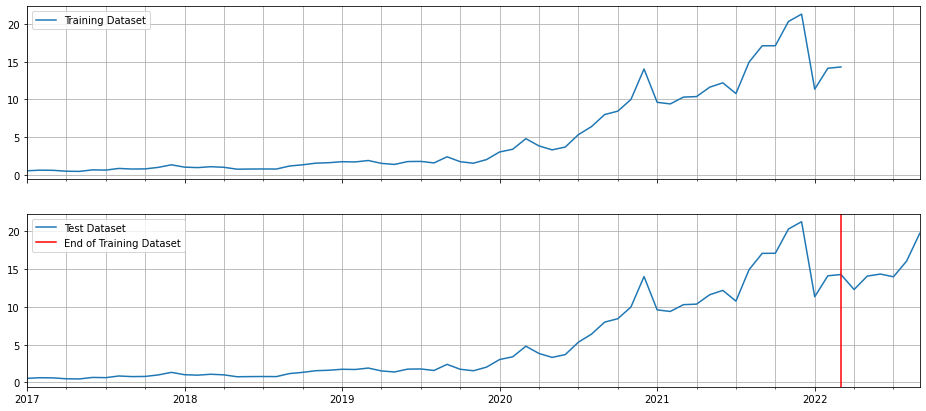

In [18]:
# Visualize Train Test Split Datasets: Method 2
train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["Training Dataset"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # End of Training dataset
ax[1].grid(which="both")
ax[1].legend(["Test Dataset", "End of Training Dataset"], loc="upper left")

plt.show()

# DeepAR: Model Training

In [19]:
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values
context_length = 46              
prediction_length = 6          
freq = "M"

estimator = DeepAREstimator(freq=freq,                                   # Data frequency
                            context_length = context_length,             # Length of Data to used for training before prediction
                            prediction_length = prediction_length,       # Length of time points to be predicted
                            num_layers = 7,                              # Number of Layers in RNN
                            num_cells = 50,                              # Number of Cells in RNN
                            cell_type = 'lstm',                          # Type of Cell in RNN
                            dropout_rate = 0.07783495658767649,          # Dropout rate between layers to avoid overfitting
                            trainer = Trainer(
                                epochs=42,                               # Num of Epochs
                                batch_size=12,                           # Num of batch size
                                num_batches_per_epoch=20,                # Num of batches per epochs in total
                                learning_rate=0.05331129708197498        # learning rate for model's internal parameters and error-update
                            ))
# Execution of DeepAR Model Training
predictor = estimator.train(training_data=training_data, num_workers=None)                             # Setting num of CPUs to 1 to avoid getting different prediction values 

100%|██████████| 20/20 [00:03<00:00,  5.44it/s, epoch=42/42, avg_epoch_loss=0.463]


# Model Evaluation
We need to specify the test dataset to achieve a model-error-metric.

In [ ]:
# First creating the forecasts
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data,       # Test dataset
                                                 predictor = predictor,     # Predictor/Fitted Model
                                                 num_samples = 100            # Number of sample paths we want for evaluation
                                                 )

# First, we can convert these generators to lists to ease further computations.
forecasts = list(forecast_it)   # Forecasted Values
tss = list(ts_it)               # Time Series Data

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let’s start with the list containing the time series, i.e., tss. We expect the first entry of tss to contain the (target of the) first time series of test_dataset.

In [21]:
# first entry of the time series list
ts_entry = tss[0]

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:6]).reshape(-1)

array([0.55, 0.63, 0.61, 0.49, 0.47, 0.67], dtype=float32)

In [22]:
# Checking 1. entry of the time series list
ts_entry = tss[0]
ts_entry

0
2017-01   0.55
2017-02   0.63
2017-03   0.61
2017-04   0.49
2017-05   0.47
...        ...
2022-05  14.08
2022-06  14.35
2022-07  13.99
2022-08  16.07
2022-09  19.74

[69 rows x 1 columns]

In [23]:
# first entry of test_dataset
test_ds_entry = next(iter(test_data))

# first 5 values
test_ds_entry["target"][:6]

array([0.55, 0.63, 0.61, 0.49, 0.47, 0.67], dtype=float32)

The entries in the forecast list are a bit more complex. They are objects that contain all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [24]:
# first entry of the forecast list
# (0. is Germany in our dataset)
forecast_entry = forecasts[0]
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id="Anteil_BEV_PKW_Deutschland", samples=numpy.array([[13.089249610900879, 13.370880126953125, 15.993240356445312, 15.052810668945312, 17.031005859375, 19.177978515625], [14.533541679382324, 12.490135192871094, 13.568977355957031, 11.583941459655762, 12.653400421142578, 18.824087142944336], [12.809331893920898, 10.634538650512695, 10.877836227416992, 9.520670890808105, 13.344136238098145, 17.64160919189453], [13.610353469848633, 13.236346244812012, 13.710813522338867, 13.105264663696289, 13.73968505859375, 17.603057861328125], [13.863717079162598, 11.83866024017334, 12.875752449035645, 15.425448417663574, 17.770511627197266, 22.09283447265625], [13.560545921325684, 11.28276252746582, 11.5033597946167, 12.963899612426758, 15.17662239074707, 18.03476905822754]], numpy.dtype("float32")), start_date=pandas.Timestamp("2022-04", freq="M"))

In [25]:
# first entry of the forecast list
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 6
Dimension of samples: (6, 6)
Start date of the forecast window: 2022-04
Frequency of the time series: <MonthEnd>


### Forecast Visualisation (1):
Without confidence interval

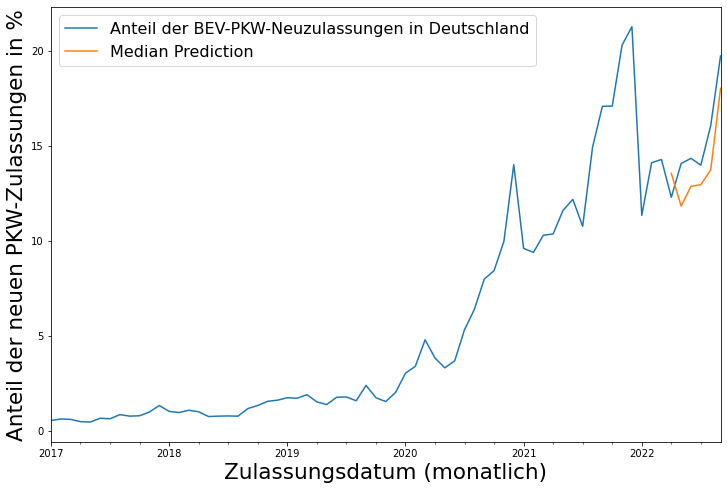

In [26]:
# Method 1: To visualize the forecasted values vs. observation/actual values (point forecast).
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                                                   # Maximum num of time points to plot. e.g. 66 time points (months)
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"]      # Label for legends in plots
    Forecast_Median = pd.DataFrame(forecast_entry.median, index=ts_entry[-6:].index)    # Creating a DataFrame with forecast median

    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry.plot(ax=ax)  # plot the time series
    Forecast_Median.plot(ax=ax)
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")


plot_prob_forecasts(ts_entry, forecast_entry)
#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])      # In case if we set a 2nd Time step for evaluation in test_data

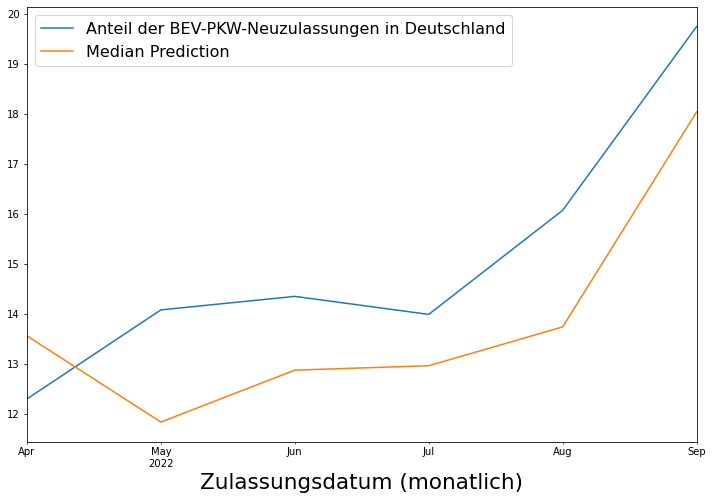

In [27]:
# Method 1: To visualize the forecasted values vs. observation/actual values (point forecast).
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                                                   # Maximum num of time points to plot. e.g. 66 time points (months)
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"]      # Label for legends in plots
    Forecast_Median = pd.DataFrame(forecast_entry.median, index=ts_entry[-6:].index)    # Creating a DataFrame with forecast median

    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry[-prediction_length:].plot(ax=ax)  # plot the time series
    Forecast_Median.plot(ax=ax)
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    #plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")


plot_prob_forecasts(ts_entry, forecast_entry)
#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])      # In case if we set a 2nd Time step for evaluation in test_data

### Forecast Visualisation (2):
With Confidence Interval

Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.

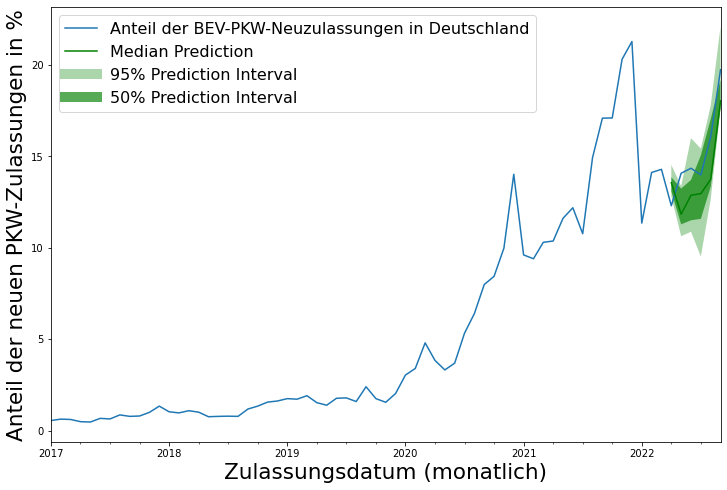

In [28]:
# Method 2: To visualize the forecasted values vs. observation (actual values) with confidence interval.
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100                                       # Maximum num of time points to plot. e.g. 66 time points (months)
    prediction_intervals = (50, 95)                     # Prediction interval to plot
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles
    
    # Visualisation configurations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ts_entry.plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
    plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
    #plt.grid()
    plt.legend(legend, fontsize=16, loc="upper left")
    plt.show()


plot_prob_forecasts(ts_entry, forecast_entry)
#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])      # In case if we set a 2nd Time step for evaluation in test_data

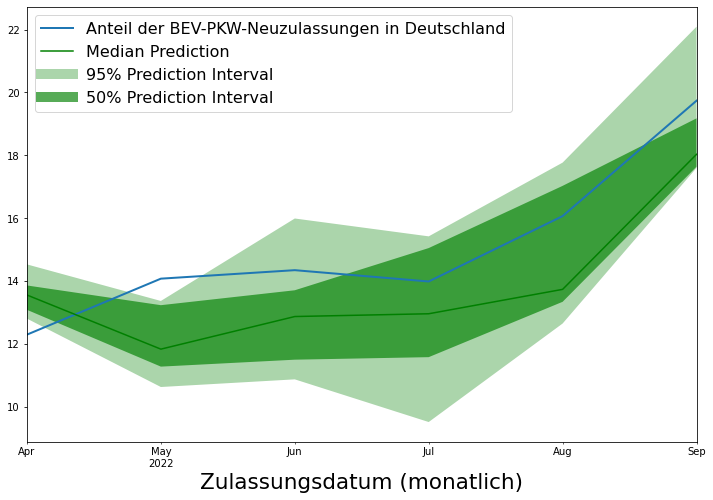

In [29]:
# Visualisation of Test-Dataset vs. Predicted Values.
def plot_forecasts(tss, forecasts, past_length, num_plots):
    prediction_intervals = (50, 95)                     # Prediction interval to plot
    legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        # Label for legends for median and actual values
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]        # Label for legends for quantiles

    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 8), linewidth=2)
        forecast.plot(prediction_intervals, color='g')
        plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
        #plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
        #plt.grid()
        plt.legend(legend, fontsize=16, loc="upper left")

plot_forecasts(tss,                 # Time Series Data
               forecasts,           # Forecast values
               past_length =6,      # Number of Months to show in Plot
               num_plots = 1)       # Number of Plots to show e.g. if we had many products to plot their forecasts.

## Error Metrics

We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [30]:
# creating evaluation instance with 50. Quantile
evaluator = Evaluator(quantiles=[0.5, 0.9])
# As default DeepAR outputs two metrics: Aggregated Metrics for all forecasts and Item Metrics for each individual product forecast
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


In [31]:
# Outputs all aggregated metrics

#from gluonts import json
#print(json.dumps(agg_metrics, indent=1))   # Method 1
agg_metrics["RMSE"]                                 # Method 2

1.2935295003076261

In [32]:
# Outputs Intem Metrics.
# As we have only one item "Batterielektrisch" due to Univariate analysis, therefore we see only one row of metrices.
item_metrics

item_id       MSE  abs_error  abs_target_sum  \
0  Anteil_BEV_PKW_Deutschland  1.673219  10.037779       90.529999   

   abs_target_mean  seasonal_error      MASE      MAPE     sMAPE        ND  \
0        15.088333        3.269608  0.511671  0.111524  0.116918  0.110878   

       MSIS  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.9]  \
0  3.763228          10.037779       0.166667           4.398258   

   Coverage[0.9]  
0            0.5

# Hyperparameter Optimization (HPO)
## Grid Search:

This grid search will go through **10800 Models** and returns a DataFrame of all models with used parameters.

**Warning:** Before running this code block please keep in mind that it will last around 10,5 days to be finished. For convenience, you can find the CSV-File of the executed Grid Search Result.

In [ ]:
# Hyperparameter Tuning: Grid Search
start_time = time.time()    # Keep record of time HPO takes

def deepar_gridearch(training_data, context_length=60, prediction_length=6, freq="M", test_data=test_data):
    '''
    training_data: Training Dataset to be used for grid search
    context_length: Length of last periods to used for forecasting and prediction_length
    prediction_length: Num of time points to be predicted.
    freq: Data frequency
    test_data: Test Dataset to used for model evaluation
    '''

    results = []

    for epoch in [5,10,15,20,25]:                                      # Num of epeochs
        for num_batche_per_epoch in [5,10,15,20,25,30]:                # Num of batch per epoch
            for batch_size in [5,10,20,30]:                            # Batch size per epoch
                for num_layers in [2,5,8,10,15,20,22,25,27,30]:        # Num of layers in RNN
                    for num_cells in [2,3,4,5,10,15,20,30,40]:         # Num of Cells in RNN
                        try:
                            mx.random.seed(7)               # Setting seed to avoid getting random prediction values
                            np.random.seed(7)               # Setting seed to avoid getting random prediction values
                            estimator = DeepAREstimator(
                                context_length = context_length,
                                prediction_length=prediction_length,
                                freq=freq,
                                num_layers = num_layers,
                                num_cells = num_cells,
                                dropout_rate=0.02,
                                trainer=Trainer(epochs=epoch,
                                                num_batches_per_epoch=num_batche_per_epoch,
                                                batch_size=batch_size,
                                                learning_rate=0.001
                                    #            callbacks=[             # These parameters are commented. See DeepAR Model Training
                                     #               ModelAveraging(avg_strategy=SelectNBestMean(num_models=2)),
                                      #              LearningRateReduction(base_lr=1e-3,
                                       #                                   decay_factor=0.5,
                                        #                                  patience=5,
                                         #                                 min_lr=0.0005, # minimum_learning_rate
                                          #                                objective="min")]
                                                )
                                )
                            # Executing the DeepAR Model trainng
                            predictor = estimator.train(training_data=training_data, num_workers = None, cache_data=True)
                            # Model Evaluation
                            forecast_it, ts_it = make_evaluation_predictions(dataset = test_data, predictor = predictor, num_samples = 6)
                            # Error Metric
                            evaluator = Evaluator(quantiles=[0.5, 0.9])
                            agg_metrics, item_metrics = evaluator(iter(list(ts_it)), iter(list(forecast_it)), num_series=len(test_data))
                            # RMSE Error
                            RMSE = agg_metrics["RMSE"]
                            # Putting together used Model Params to "results" list.
                            result = [epoch, num_batche_per_epoch, batch_size, num_layers, num_cells, round(RMSE, 3)]
                            # To show progress: Printing currently used params in Model Training
                            print(f'\n{len(results)+1}  of  1575 Models – Combination:\t{result}')
                            # Appending used Model Params to "results" list.
                            results.append(result)
                        except:
                            continue
    # Creating a DataFrame our of "results" list
    results_df = pd.DataFrame(results, columns=['Epochs', 'num_batches_per_epoch', 'batch_size', 'Num_Layers', 'Num_Cells', 'RMSE'])
    # Soreting DataFrame values according to RMSE values
    results_df = results_df.sort_values(by=['RMSE'], ascending=True)
    # Returning Grid Search result as a DataFrame
    return results_df
# Applying the Grid Search Function
deepar_gridsearch_results = deepar_gridearch(training_data, context_length=60, prediction_length=6, freq="M", test_data=test_data)
# Saving the Grid Search as a CSV-File
deepar_gridsearch_results.to_csv('Path/To/Dataset/01_DeepAR_gridsearch_RMSE_6MonthsForecast_V1.csv')
# Checking the amount of time it took for DeepAR-Gridsearch
print(f"\nTime spent for DeepAR grid search (Minutes):\t{round((time.time() - start_time)/60, 2)}")                        

deepar_gridsearch_results

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



10679  of  10800 Models – Combination:	[25, 30, 20, 22, 10, 14.789]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



10680  of  10800 Models – Combination:	[25, 30, 20, 22, 15, 12.982]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



10681  of  10800 Models – Combination:	[25, 30, 20, 22, 20, 8.495]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



10682  of  10800 Models – Combination:	[25, 30, 20, 22, 30, 2.461]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



10683  of  10800 Models – Combination:	[25, 30, 20, 22, 40, 7.58]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



10684  of  10800 Models – Combination:	[25, 30, 20, 25, 2, 8.579]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



10685  of  10800 Models – Combination:	[25, 30, 20, 25, 3, 12.965]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



10686  of  10800 Models – Combination:	[25, 30, 20, 25, 4, 9.141]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



10687  of  10800 Models – Combination:	[25, 30, 20, 25, 5, 12.455]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



10688  of  10800 Models – Combination:	[25, 30, 20, 25, 10, 8.385]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



10689  of  10800 Models – Combination:	[25, 30, 20, 25, 15, 13.136]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



10690  of  10800 Models – Combination:	[25, 30, 20, 25, 20, 6.431]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



10691  of  10800 Models – Combination:	[25, 30, 20, 25, 30, 6.947]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



10692  of  10800 Models – Combination:	[25, 30, 20, 25, 40, 4.07]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



10693  of  10800 Models – Combination:	[25, 30, 20, 27, 2, 6.912]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



10694  of  10800 Models – Combination:	[25, 30, 20, 27, 3, 8.451]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



10695  of  10800 Models – Combination:	[25, 30, 20, 27, 4, 5.722]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



10696  of  10800 Models – Combination:	[25, 30, 20, 27, 5, 5.963]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



10697  of  10800 Models – Combination:	[25, 30, 20, 27, 10, 13.142]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



10698  of  10800 Models – Combination:	[25, 30, 20, 27, 15, 20.123]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



10699  of  10800 Models – Combination:	[25, 30, 20, 27, 20, 3.514]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



10700  of  10800 Models – Combination:	[25, 30, 20, 27, 30, 7.187]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



10701  of  10800 Models – Combination:	[25, 30, 20, 27, 40, 1.884]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



10702  of  10800 Models – Combination:	[25, 30, 20, 30, 2, 7.852]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



10703  of  10800 Models – Combination:	[25, 30, 20, 30, 3, 10.409]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



10704  of  10800 Models – Combination:	[25, 30, 20, 30, 4, 6.291]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



10705  of  10800 Models – Combination:	[25, 30, 20, 30, 5, 14.211]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



10706  of  10800 Models – Combination:	[25, 30, 20, 30, 10, 13.655]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



10707  of  10800 Models – Combination:	[25, 30, 20, 30, 15, 5.131]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



10708  of  10800 Models – Combination:	[25, 30, 20, 30, 20, 16.008]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



10709  of  10800 Models – Combination:	[25, 30, 20, 30, 30, 2.883]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



10710  of  10800 Models – Combination:	[25, 30, 20, 30, 40, 4.705]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



10711  of  10800 Models – Combination:	[25, 30, 30, 2, 2, 3.033]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



10712  of  10800 Models – Combination:	[25, 30, 30, 2, 3, 8.595]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



10713  of  10800 Models – Combination:	[25, 30, 30, 2, 4, 3.316]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



10714  of  10800 Models – Combination:	[25, 30, 30, 2, 5, 5.149]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]



10715  of  10800 Models – Combination:	[25, 30, 30, 2, 10, 4.362]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



10716  of  10800 Models – Combination:	[25, 30, 30, 2, 15, 5.234]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



10717  of  10800 Models – Combination:	[25, 30, 30, 2, 20, 3.912]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



10718  of  10800 Models – Combination:	[25, 30, 30, 2, 30, 5.01]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



10719  of  10800 Models – Combination:	[25, 30, 30, 2, 40, 7.972]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



10720  of  10800 Models – Combination:	[25, 30, 30, 5, 2, 4.237]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



10721  of  10800 Models – Combination:	[25, 30, 30, 5, 3, 6.305]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



10722  of  10800 Models – Combination:	[25, 30, 30, 5, 4, 6.264]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



10723  of  10800 Models – Combination:	[25, 30, 30, 5, 5, 10.592]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]



10724  of  10800 Models – Combination:	[25, 30, 30, 5, 10, 6.921]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



10725  of  10800 Models – Combination:	[25, 30, 30, 5, 15, 13.374]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]



10726  of  10800 Models – Combination:	[25, 30, 30, 5, 20, 6.274]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



10727  of  10800 Models – Combination:	[25, 30, 30, 5, 30, 11.455]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



10728  of  10800 Models – Combination:	[25, 30, 30, 5, 40, 8.418]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]



10729  of  10800 Models – Combination:	[25, 30, 30, 8, 2, 3.847]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



10730  of  10800 Models – Combination:	[25, 30, 30, 8, 3, 3.635]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



10731  of  10800 Models – Combination:	[25, 30, 30, 8, 4, 4.921]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



10732  of  10800 Models – Combination:	[25, 30, 30, 8, 5, 11.541]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



10733  of  10800 Models – Combination:	[25, 30, 30, 8, 10, 9.385]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



10734  of  10800 Models – Combination:	[25, 30, 30, 8, 15, 14.215]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



10735  of  10800 Models – Combination:	[25, 30, 30, 8, 20, 10.9]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



10736  of  10800 Models – Combination:	[25, 30, 30, 8, 30, 10.799]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



10737  of  10800 Models – Combination:	[25, 30, 30, 8, 40, 12.945]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



10738  of  10800 Models – Combination:	[25, 30, 30, 10, 2, 2.514]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



10739  of  10800 Models – Combination:	[25, 30, 30, 10, 3, 11.653]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



10740  of  10800 Models – Combination:	[25, 30, 30, 10, 4, 3.812]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



10741  of  10800 Models – Combination:	[25, 30, 30, 10, 5, 5.387]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



10742  of  10800 Models – Combination:	[25, 30, 30, 10, 10, 6.773]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



10743  of  10800 Models – Combination:	[25, 30, 30, 10, 15, 13.921]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



10744  of  10800 Models – Combination:	[25, 30, 30, 10, 20, 16.677]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



10745  of  10800 Models – Combination:	[25, 30, 30, 10, 30, 7.749]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



10746  of  10800 Models – Combination:	[25, 30, 30, 10, 40, 5.708]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



10747  of  10800 Models – Combination:	[25, 30, 30, 15, 2, 7.272]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



10748  of  10800 Models – Combination:	[25, 30, 30, 15, 3, 5.424]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



10749  of  10800 Models – Combination:	[25, 30, 30, 15, 4, 5.86]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



10750  of  10800 Models – Combination:	[25, 30, 30, 15, 5, 12.409]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



10751  of  10800 Models – Combination:	[25, 30, 30, 15, 10, 8.134]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



10752  of  10800 Models – Combination:	[25, 30, 30, 15, 15, 4.726]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



10753  of  10800 Models – Combination:	[25, 30, 30, 15, 20, 8.185]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



10754  of  10800 Models – Combination:	[25, 30, 30, 15, 30, 7.554]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



10755  of  10800 Models – Combination:	[25, 30, 30, 15, 40, 5.058]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



10756  of  10800 Models – Combination:	[25, 30, 30, 20, 2, 5.854]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



10757  of  10800 Models – Combination:	[25, 30, 30, 20, 3, 11.632]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



10758  of  10800 Models – Combination:	[25, 30, 30, 20, 4, 15.409]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



10759  of  10800 Models – Combination:	[25, 30, 30, 20, 5, 15.086]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



10760  of  10800 Models – Combination:	[25, 30, 30, 20, 10, 18.243]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



10761  of  10800 Models – Combination:	[25, 30, 30, 20, 15, 6.731]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



10762  of  10800 Models – Combination:	[25, 30, 30, 20, 20, 5.632]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



10763  of  10800 Models – Combination:	[25, 30, 30, 20, 30, 4.145]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



10764  of  10800 Models – Combination:	[25, 30, 30, 20, 40, 4.028]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



10765  of  10800 Models – Combination:	[25, 30, 30, 22, 2, 9.845]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]



10766  of  10800 Models – Combination:	[25, 30, 30, 22, 3, 6.09]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]



10767  of  10800 Models – Combination:	[25, 30, 30, 22, 4, 5.827]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



10768  of  10800 Models – Combination:	[25, 30, 30, 22, 5, 5.838]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



10769  of  10800 Models – Combination:	[25, 30, 30, 22, 10, 6.366]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



10770  of  10800 Models – Combination:	[25, 30, 30, 22, 15, 11.872]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



10771  of  10800 Models – Combination:	[25, 30, 30, 22, 20, 9.939]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]



10772  of  10800 Models – Combination:	[25, 30, 30, 22, 30, 11.741]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



10773  of  10800 Models – Combination:	[25, 30, 30, 22, 40, 3.202]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



10774  of  10800 Models – Combination:	[25, 30, 30, 25, 2, 21.931]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



10775  of  10800 Models – Combination:	[25, 30, 30, 25, 3, 6.824]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



10776  of  10800 Models – Combination:	[25, 30, 30, 25, 4, 6.019]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



10777  of  10800 Models – Combination:	[25, 30, 30, 25, 5, 10.112]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



10778  of  10800 Models – Combination:	[25, 30, 30, 25, 10, 8.359]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]



10779  of  10800 Models – Combination:	[25, 30, 30, 25, 15, 5.314]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



10780  of  10800 Models – Combination:	[25, 30, 30, 25, 20, 4.445]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



10781  of  10800 Models – Combination:	[25, 30, 30, 25, 30, 5.486]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



10782  of  10800 Models – Combination:	[25, 30, 30, 25, 40, 2.881]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]



10783  of  10800 Models – Combination:	[25, 30, 30, 27, 2, 10.867]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



10784  of  10800 Models – Combination:	[25, 30, 30, 27, 3, 10.173]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



10785  of  10800 Models – Combination:	[25, 30, 30, 27, 4, 9.114]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



10786  of  10800 Models – Combination:	[25, 30, 30, 27, 5, 12.651]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



10787  of  10800 Models – Combination:	[25, 30, 30, 27, 10, 9.548]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



10788  of  10800 Models – Combination:	[25, 30, 30, 27, 15, 13.036]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



10789  of  10800 Models – Combination:	[25, 30, 30, 27, 20, 4.902]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



10790  of  10800 Models – Combination:	[25, 30, 30, 27, 30, 6.417]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



10791  of  10800 Models – Combination:	[25, 30, 30, 27, 40, 5.867]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



10792  of  10800 Models – Combination:	[25, 30, 30, 30, 2, 4.743]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



10793  of  10800 Models – Combination:	[25, 30, 30, 30, 3, 10.717]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



10794  of  10800 Models – Combination:	[25, 30, 30, 30, 4, 14.328]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



10795  of  10800 Models – Combination:	[25, 30, 30, 30, 5, 12.762]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



10796  of  10800 Models – Combination:	[25, 30, 30, 30, 10, 12.987]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



10797  of  10800 Models – Combination:	[25, 30, 30, 30, 15, 10.661]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



10798  of  10800 Models – Combination:	[25, 30, 30, 30, 20, 10.55]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



10799  of  10800 Models – Combination:	[25, 30, 30, 30, 30, 3.738]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



10800  of  10800 Models – Combination:	[25, 30, 30, 30, 40, 6.196]

Time spent for DeepAR grid search (Minutes):	15212.96


Epochs  num_batches_per_epoch  batch_size  Num_Layers  Num_Cells  \
8540      20                     30          20          27         40   
3814      10                     25          20          10         30   
8587      20                     30          30          15          3   
1578       5                     25          10          20          5   
1128       5                     20           5          20          5   
...      ...                    ...         ...         ...        ...   
314        5                      5          30          15         40   
3304      10                     20           5          25          3   
8343      20                     30           5          25          2   
505        5                     10          10          22          3   
3547      10                     20          30          15          3   

         RMSE  
8540    0.663  
3814    0.676  
8587    0.948  
1578    1.057  
1128    1.172  
...       ...  
314    39.466  
3304   40.157  
8343   43.010  
505    44.031  
3547  120.177  

[10800 rows x 6 columns]

## Optuna HPO

Optuna has 2 parts:

   * **Objective function:** To define which params and how the model should be trained as well as based on which error metric should Optuna optimize all process.
   * **Trail:** To specify how many times optuna should run to find the best parameter-combination for DeepAR Model.

In [78]:
# Optuna's Objective Function:

class DeepARTuningObjective:
    def __init__(self, training_data=training_data, test_data=test_data, prediction_length=6, freq='M', metric_type='RMSE'):
        """
            Dataset: Dataset
            prediction_length: Length of prediction horizon
            freq: Data Frequency
            metric_type: Type error metric for model evaluation
        """

        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type
        self.training_dataset = training_data                   # Sepecifying Training Dataset
        self.test_dataset = test_data                           # Specifiying Test Dataset

    """
    get_params() Function: Sets types and size of all parameters for HPO process with Optuna:
         trial.suggest_int():           Used for params that take integers values.
         trial.suggest_float():         Used for params that take float values.
         trial.suggest_categorical()    Used for params that take categorical values.
    """
    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 2, 30),
            "num_cells": trial.suggest_int("num_cells", 2, 100),
            "dropout_rate": trial.suggest_float("dropout_rate", 0.00, 0.2),
            "epochs": trial.suggest_int("epochs", 5, 50),
            "batch_size": trial.suggest_int("batch_size", 5, 30),
            "num_batches_per_epoch": trial.suggest_int("num_batches_per_epoch", 5, 30),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "context_length": trial.suggest_int("context_length", 2, 63),
        }

    """
    __call__() Function:
        Takes all the specified params,
        Uses splited datset,
        trains the DeepAR Model,
        then return the RMSE Error accordingly
    """
    def __call__(self, trial):
        params = self.get_params(trial)
        mx.random.seed(7)               # Setting seed to avoid getting random prediction values
        np.random.seed(7)               # Setting seed to avoid getting random prediction values

        estimator = DeepAREstimator(
            context_length=params["context_length"],
            freq = self.freq,
            prediction_length = self.prediction_length,
            num_layers = params["num_layers"],
            num_cells = params["num_cells"],
            cell_type = "lstm",
            dropout_rate = params["dropout_rate"],
            trainer = Trainer(
                epochs = params["epochs"],   # Number of Epochs
                batch_size = params["batch_size"],
                num_batches_per_epoch = params["num_batches_per_epoch"],
                learning_rate = params["learning_rate"]
    #            callbacks=[
     #               #ModelAveraging(avg_strategy=SelectNBestMean(num_models=1)),
      #              LearningRateReduction(
       #                 base_lr=1e-3,
        #                decay_factor=0.5,
         #               patience=6,
          #              min_lr=5e-5, # minimum_learning_rate
           #             objective="min")
            #    ],
            )
        )
       
        predictor = estimator.train(self.training_dataset, num_workers=None)      # Num of CPUs to 1 to avoid getting random values
        forecast_it, ts_it=make_evaluation_predictions(dataset = test_data,         # Test dataset
                                                       predictor = predictor,       # Predictor/Fitted Model
                                                       num_samples = 6)             # Number of sample paths we want for evaluation
        forecasts = list(forecast_it)
        tss = list(ts_it)                                                           # Time Series Data
        evaluator = Evaluator(quantiles=[0.5, 0.9]) 
        agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(self.test_dataset))
      
        # Returns RMSE aggregated metric
        RMSE = agg_metrics[self.metric_type]
        return RMSE

Optuna's Execution for HPO:

In [ ]:
start_time = time.time()        # Keep record of time HPO takes

# Make the sampler behave in a deterministic way.
sampler = TPESampler(seed=7)
study = optuna.create_study(sampler=sampler, study_name='DeepAR Model (Univariate Time Series Analysis)',       # Name for current Optuna HPO
                            direction="minimize"                                                                # Purpose of Param-Tuning -> to minimize the Model-Error
                            )

study.optimize(
    DeepARTuningObjective(training_data=training_data, test_data=test_data, prediction_length=6, freq='M', metric_type='RMSE'),
                          n_trials=100)        # Num of Trails to search for
                          #n_jobs=2            # Num of CPUs to use. "-1" means use all CPU but won'T be optimal when exceting on cloud resources.


# Outputs num of Trails finished
print(f"Number of finished trials:\t{len(study.trials)}")
# Shows best trail value
trial = study.best_trial
print(f"\nBest trial's Value:\t\t{trial.value}")
# Shows params used for best trials
print("\nParams: ")
for key, value in trial.params.items():
    print(f" {key}:\t{value}")
# Shows time spent for current Optuna HPO Proces (in minutes)
print(f"\nTime spent for HPO:\t{round((time.time() - start_time)/60, 2)}  Minutes")

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
[I 2022-11-09 02:57:39,322] Trial 67 finished with value: 101.68832590322253 and parameters: {'num_layers': 14, 'num_cells': 58, 'dropout_rate': 0.08634703427815983, 'epochs': 36, 'batch_size': 15, 'num_batches_per_epoch': 18, 'learning_rate': 0.057340496673120904, 'context_length': 42}. Best is trial 35 with value: 1.694820021955034.
Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
[I 2022-11-09 03:00:30,354] Trial 68 finished with value: 1.2935295003076261 and parameters: {'num_layers': 7, 'num_cells': 50, 'dropout_rate': 0.07783495658767649, 'epochs': 42, 'batch_size': 12, 'num_batches_per_epoch': 20, 'learning_rate': 0.05331129708197498, 'context_length': 46}. Best is trial 68 with value: 1.2935295003076261.
Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
[I 2022-11-09 03:01:04,422] Trial 69 finished with value: 6.841236413521323 and parameters: {'num_layers': 5, 'num_cells': 47, 'd

Number of finished trials:	100

Best trial's Value:		1.2935295003076261

Params: 
 num_layers:	7
 num_cells:	50
 dropout_rate:	0.07783495658767649
 epochs:	42
 batch_size:	12
 num_batches_per_epoch:	20
 learning_rate:	0.05331129708197498
 context_length:	46

Time spent for HPO:	402.78  Minutes


In [ ]:
#trial.params

#### Saving Optuna HPO Study

In [ ]:
# Saving Optuna HPO Study
joblib.dump(study, "Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V3.pkl")

# To Load Optuna Study
#study = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V3.pkl")
#print(f"Number of finished trials:\t{len(study.trials)}")
#trial = study.best_trial
#print(f"\nBest trial's Value:\t\t{trial.value}")
#print("\nParams: ")
#for key, value in trial.params.items():
#   print(f" {key}:\t{value}")

Optuna provides nice visualisation for each study (HPO Process with Optuna). To visualise each of these functionalites, we need import Optuna based Plotting Methods:

In [73]:
# Returns Optuna's Tuning results as a DataFrame
optuna_result = study.trials_dataframe()
optuna_result

number     value             datetime_start          datetime_complete  \
0        0  4.138246 2022-11-08 22:07:21.765620 2022-11-08 22:07:54.474099   
1        1  6.726046 2022-11-08 22:07:54.475706 2022-11-08 22:09:19.940946   
2        2  7.896570 2022-11-08 22:09:19.942659 2022-11-08 22:09:56.353359   
3        3  6.698527 2022-11-08 22:09:56.355308 2022-11-08 22:14:11.108380   
4        4  3.603282 2022-11-08 22:14:11.110489 2022-11-08 22:15:49.256973   
..     ...       ...                        ...                        ...   
95      95  6.121639 2022-11-09 04:43:10.389286 2022-11-09 04:44:45.515070   
96      96  5.134012 2022-11-09 04:44:45.517125 2022-11-09 04:46:16.499185   
97      97  4.621232 2022-11-09 04:46:16.501272 2022-11-09 04:46:57.139992   
98      98  3.629205 2022-11-09 04:46:57.142041 2022-11-09 04:48:28.930629   
99      99  9.484590 2022-11-09 04:48:28.932516 2022-11-09 04:50:08.342454   

                 duration  params_batch_size  params_context_length  \
0  0 days 00:00:32.708479                 30                      6   
1  0 days 00:01:25.465240                 14                     58   
2  0 days 00:00:36.410700                 20                     36   
3  0 days 00:04:14.753072                 22                     32   
4  0 days 00:01:38.146484                 24                     19   
..                    ...                ...                    ...   
95 0 days 00:01:35.125784                  6                     45   
96 0 days 00:01:30.982060                  5                     39   
97 0 days 00:00:40.638720                  6                     33   
98 0 days 00:01:31.788588                  7                     37   
99 0 days 00:01:39.409938                  7                     41   

    params_dropout_rate  params_epochs  params_learning_rate  \
0              0.087682             38              0.050611   
1              0.135846             41              0.029526   
2              0.186241              6              0.023800   
3              0.104683             39              0.021280   
4              0.073178             43              0.057690   
..                  ...            ...                   ...   
95             0.149734             49              0.033227   
96             0.157263             45              0.029853   
97             0.175638             42              0.017128   
98             0.189053             46              0.036655   
99             0.195961             43              0.014184   

    params_num_batches_per_epoch  params_num_cells  params_num_layers  \
0                             19                79                  4   
1                              6                51                  9   
2                             29                46                  8   
3                             17                15                 28   
4                             13                49                 12   
..                           ...               ...                ...   
95                             8                28                 11   
96                             6                37                 15   
97                             5                21                 12   
98                             9                42                 10   
99                             7                79                  9   

       state  
0   COMPLETE  
1   COMPLETE  
2   COMPLETE  
3   COMPLETE  
4   COMPLETE  
..       ...  
95  COMPLETE  
96  COMPLETE  
97  COMPLETE  
98  COMPLETE  
99  COMPLETE  

[100 rows x 14 columns]

In [74]:
# Sorting Optuna's results according to its values
# This allows us to see all the lowest errors first
optuna_result = optuna_result.sort_values(by='value', ascending=True)
optuna_result

number       value             datetime_start          datetime_complete  \
68      68    1.293530 2022-11-09 02:57:39.323365 2022-11-09 03:00:30.354152   
35      35    1.694820 2022-11-09 00:21:59.235930 2022-11-09 00:22:41.348101   
33      33    2.010545 2022-11-09 00:20:24.705081 2022-11-09 00:21:10.295700   
85      85    2.050224 2022-11-09 04:15:56.681047 2022-11-09 04:20:56.176889   
34      34    2.215027 2022-11-09 00:21:10.297427 2022-11-09 00:21:59.234097   
..     ...         ...                        ...                        ...   
73      73   76.886610 2022-11-09 03:23:52.697227 2022-11-09 03:29:11.552554   
67      67  101.688326 2022-11-09 02:44:37.524587 2022-11-09 02:57:39.321491   
15      15  102.304670 2022-11-08 23:12:43.458142 2022-11-08 23:13:52.135545   
12      12  124.321916 2022-11-08 22:28:35.407496 2022-11-08 22:59:57.597134   
30      30  138.304559 2022-11-09 00:15:40.271630 2022-11-09 00:18:52.251135   

                 duration  params_batch_size  params_context_length  \
68 0 days 00:02:51.030787                 12                     46   
35 0 days 00:00:42.112171                  5                     37   
33 0 days 00:00:45.590619                  5                     37   
85 0 days 00:04:59.495842                 12                     48   
34 0 days 00:00:48.936670                  5                     37   
..                    ...                ...                    ...   
73 0 days 00:05:18.855327                 13                     53   
67 0 days 00:13:01.796904                 15                     42   
15 0 days 00:01:08.677403                 25                     51   
12 0 days 00:31:22.189638                 15                     48   
30 0 days 00:03:11.979505                 30                     17   

    params_dropout_rate  params_epochs  params_learning_rate  \
68             0.077835             42              0.053311   
35             0.173405             40              0.014865   
33             0.149885             35              0.029761   
85             0.137960             41              0.036020   
34             0.169616             41              0.013993   
..                  ...            ...                   ...   
73             0.090131             32              0.099234   
67             0.086347             36              0.057340   
15             0.130790             10              0.076528   
12             0.058574             49              0.098048   
30             0.115507             24              0.050471   

    params_num_batches_per_epoch  params_num_cells  params_num_layers  \
68                            20                50                  7   
35                             5                67                  7   
33                             5                53                 10   
85                            20                36                 15   
34                             5                54                  9   
..                           ...               ...                ...   
73                            20                41                 10   
67                            18                58                 14   
15                             7                61                 18   
12                            24                96                 14   
30                            16                50                 17   

       state  
68  COMPLETE  
35  COMPLETE  
33  COMPLETE  
85  COMPLETE  
34  COMPLETE  
..       ...  
73  COMPLETE  
67  COMPLETE  
15  COMPLETE  
12  COMPLETE  
30  COMPLETE  

[100 rows x 14 columns]

In [97]:
# Visualising the optimizsation history. It shows how (Optuna's) Error decreased over time.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_optimization_history.html#optuna.visualization.plot_optimization_history
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [96]:
# Visualize parameter importances
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_param_importances.html#optuna.visualization.plot_param_importances
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [98]:
# Check which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [99]:
# Visualize high-dimensional parameter relationships.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_parallel_coordinate.html#optuna.visualization.plot_parallel_coordinate
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [112]:
# Select specific parameters to visualize.
plot_parallel_coordinate(study, params=["learning_rate", "batch_size"])

In [101]:
# Visualize hyperparameter relationships
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html#optuna.visualization.plot_contour
from optuna.visualization import plot_contour
plot_contour(study)

In [111]:
# Visualize specific hyperparameter relationships
plot_contour(study, params=["learning_rate", "batch_size"])

In [108]:
# Visualize individual hyperparameters as slice plot.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html#optuna.visualization.plot_slice
from optuna.visualization import plot_slice
plot_slice(study)

In [113]:
# Select specific parameters to visualize as slice plot.
plot_slice(study, params=["learning_rate", "batch_size"])

In [ ]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
study_sarima = joblib.load("Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
study_sarima.study_name='SARIMA Model'
study_sarimax = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
study_sarimax.study_name='SARIMAX Model'
study_deepAR_univariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V1.pkl")
study_deepAR_univariate_tsa.study_name='DeepAR Model (Univariate)'
study_deepAR_multivariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
study_deepAR_multivariate_tsa.study_name='DeepAR Model (Multivariate)'

plot_edf([study_sarima, study_sarimax, study_deepAR_univariate_tsa, study_deepAR_multivariate_tsa])

In [ ]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
study_sarima = joblib.load("Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
study_sarima.study_name='SARIMA Model'
study_sarimax = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
study_sarimax.study_name='SARIMAX Model'
study_deepAR_univariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V1.pkl")
study_deepAR_univariate_tsa.study_name='DeepAR Model (Univariate)'
study_deepAR_multivariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
study_deepAR_multivariate_tsa.study_name='DeepAR Model (Multivariate)'

plot_edf([study_sarima, study_sarimax, study_deepAR_univariate_tsa, study_deepAR_multivariate_tsa])

# Re-Train Model on full dataset

In [33]:
freq = "M"                                              # Data frequency – "M" means monthly dataset
prediction_length = 6                                   # Number of future values to be forecasted. It's the prediction length of time series – This can not be changed once the model is trained

# Creating Test Dataset
training_data_full = ListDataset(
    [
        {
            "start": df.index[0],                       # Starting Date in Test Dataset
            "target": df.Anteil_BEV_PKW_Deutschland,            # End Date + Data for Test Dataset
            "item_id" : "Anteil_BEV_PKW_Deutschland"    # Name for this product – Only useful if we had many products to forecast simultaneously.
        }
    ],
    freq = freq                                         # Data Frequency – For Monthly Data it is always "M", Quarterly "Q", yearly "Y2 etc.
)

mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values

# Execution of DeepAR Model Training
predictor = estimator.train(training_data=training_data_full, num_workers=None)      # Num of CPUs to 1 to avoid getting random values

100%|██████████| 20/20 [00:04<00:00,  4.03it/s, epoch=42/42, avg_epoch_loss=-.73]


# Forecasting to future
After training the DeepAR Model, we can start forcasting to the future.

Basically, DeepAR won't predict more than 6 months because we set "prediction_length = 6"


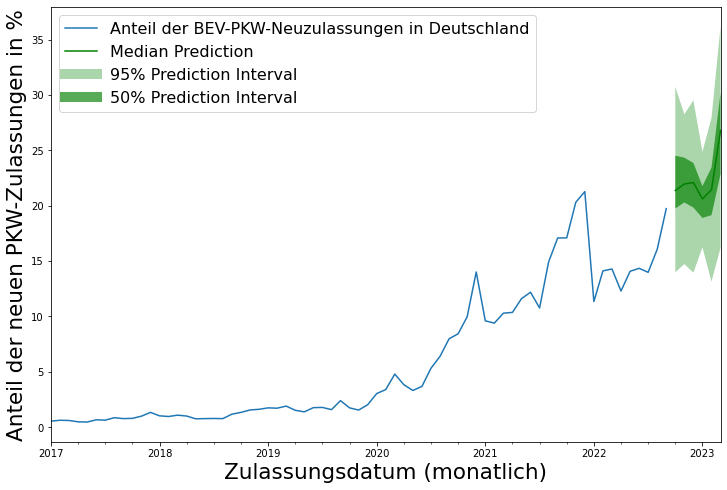

In [34]:
# Visualisation of 6 months forecasts for Germany with 95% confidence interval
# We create an instance of variable so that the predict method can forcast from that time.
# Now using "predict" method to forecast the specified time frame.
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values

predict_6months = predictor.predict(training_data_full)
# Specify the desired confidence interval
prediction_intervals = (50, 95)
# Label for legends 
legend = ["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Median Prediction"] + [        
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]      
 
df.plot(figsize=(12,8))
for prediction in predict_6months:
    prediction.plot(prediction_intervals=prediction_intervals, color="green")

plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
#plt.grid()
plt.legend(legend, fontsize=16, loc="upper left")
plt.show()

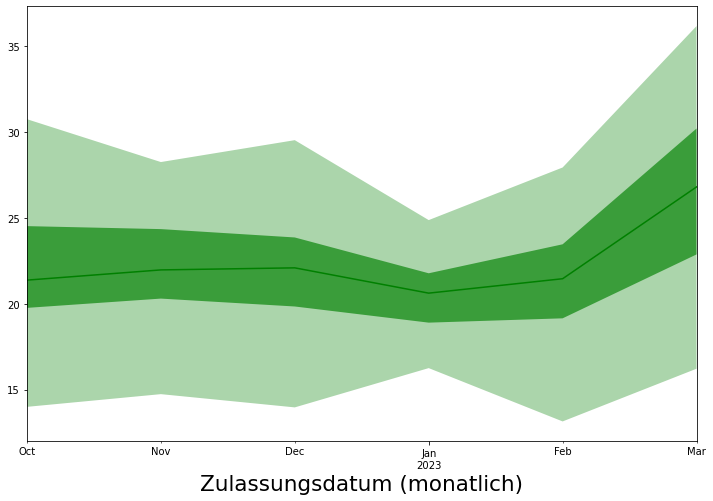

In [37]:
# Visualisation of 6 months forecasts for Germany with 95% confidence interval
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values
predict_6months = predictor.predict(training_data_full)
# Specify the desired confidence interval
prediction_intervals = (50, 95)
# Label for legends 
legend = ["Median Prediction"] + [        
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]      

for prediction in predict_6months:
    plt.figure(figsize=(12,8))
    prediction.plot(prediction_intervals=prediction_intervals, color="green")
plt.xlabel('Zulassungsdatum (monatlich)', size=21.5)
#plt.ylabel('Anteil der neuen PKW-Zulassungen in %', size=21.5)
#plt.legend(legend, fontsize=16, loc="upper left")
plt.show()

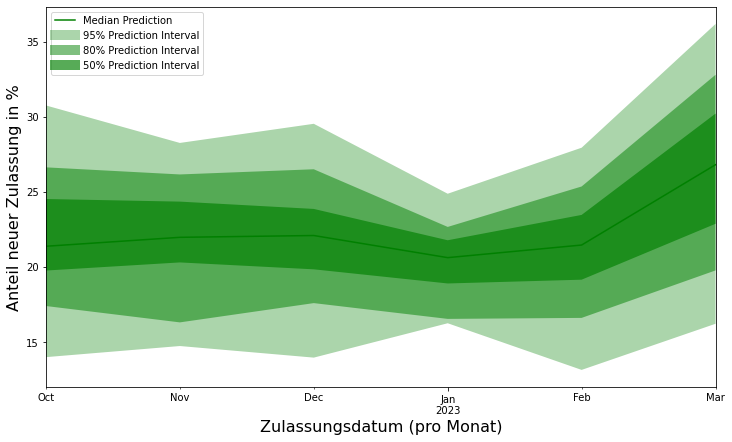

In [39]:
# Visualisation of 6 months forecasts for Germany with 95% confidence interval
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values
predict_6months = predictor.predict(training_data_full)
# Specify the desired confidence interval
prediction_intervals = (50, 80, 95)
# Label for legends 
legend = ["Median Prediction"] + [        
        f"{k}% Prediction Interval" for k in prediction_intervals][::-1]      

for prediction in predict_6months:
    plt.figure(figsize=(12,7))
    prediction.plot(prediction_intervals=prediction_intervals, color="green")
plt.xlabel('Zulassungsdatum (pro Monat)', size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(legend, loc="upper left")
plt.show()

### Generate Forecasts for Germany

In [40]:
mx.random.seed(7)               # Setting seed to avoid getting random prediction values
np.random.seed(7)               # Setting seed to avoid getting random prediction values

predict_6months = predictor.predict(training_data_full)
# In DeepAR, it is not straigth foreward to get the predicted values. Thus, we need convert it to a list (Multi-Arrays) first.
predict_6months_list = list(predict_6months)
# Getting the first values from the array, which is forecast for Germany
predict_6months_germany = predict_6months_list[0]

In [41]:
# 95% Confidence Interval
# Converting the predicted 6 months to DataFrame consisting 95% confidence interval
df_future_6months_germany_CI_95 = pd.DataFrame({'Median Value':predict_6months_germany.median, 'Lower Bound 95%_CI':predict_6months_germany.quantile(0.025), 'Upper Bound 95%_CI':predict_6months_germany.quantile(0.975), 'Lower Bound 50%_CI':predict_6months_germany.quantile(0.25), 'Upper Bound 50%_CI':predict_6months_germany.quantile(0.75)}, index=pd.date_range(start="2022-10-01", periods=prediction_length, freq="MS"))
df_future_6months_germany_CI_95.to_csv("Path/To/Dataset/Prediction_6Months_DeepAR_Model.csv")
df_future_6months_germany_CI_95

Median Value  Lower Bound 95%_CI  Upper Bound 95%_CI  \
2022-10-01     21.373526           13.992926           30.747110   
2022-11-01     21.968674           14.732599           28.250845   
2022-12-01     22.088821           13.961171           29.525446   
2023-01-01     20.615812           16.249210           24.870159   
2023-02-01     21.455189           13.143373           27.933693   
2023-03-01     26.802826           16.214190           36.169746   

            Lower Bound 50%_CI  Upper Bound 50%_CI  
2022-10-01           19.757170           24.518970  
2022-11-01           20.297987           24.345060  
2022-12-01           19.838099           23.858522  
2023-01-01           18.897430           21.772278  
2023-02-01           19.148706           23.460161  
2023-03-01           22.870663           30.204664

In [42]:
# 80% Confidence Interval
# Converting the predicted 6 months to DataFrame consisting 80% confidence interval
df_future_6months_germany_CI_80 = pd.DataFrame({'Median Value':predict_6months_germany.median, 'Lower Bound 80%_CI':predict_6months_germany.quantile(0.10), 'Upper Bound 80%_CI':predict_6months_germany.quantile(0.90)}, index=pd.date_range(start="2022-10-01", periods=prediction_length, freq="MS"))
#df_future_6months_germany_CI_80.to_csv("Path/To/Dataset/Prediction_germany_80%_conf_interval.csv")
df_future_6months_germany_CI_80

Median Value  Lower Bound 80%_CI  Upper Bound 80%_CI
2022-10-01     21.373526           17.396053           26.625984
2022-11-01     21.968674           16.306463           26.153534
2022-12-01     22.088821           17.589676           26.498390
2023-01-01     20.615812           16.538984           22.660658
2023-02-01     21.455189           16.605236           25.352503
2023-03-01     26.802826           19.765213           32.788052

# Saving and Loading Trained DeepAR Model

In [44]:
# save the trained DeepAR Model:
#predictor.serialize(Path("Path/To/Dataset/03_Model_Three_File_V18_Best_Model3"))

In [44]:
# loads the trained DeepAR Model back:
#predictor = Predictor.deserialize(Path("Path/To/Dataset/03_Model_Three_File_V18_Best_Model3"))

<div class="alert alert-info"><h3>Conclusion:</h3>
This ist the final version of DeepAR's Univariate Time Series Analysis.<br>
</div>